In [84]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary

cudnn.benchmark = True
plt.ion()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset

In [85]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [86]:
#apple
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


Load Data

In [87]:

data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = '/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/train/good'
train_dataset = CustomDataset(data_dir,data_transforms)
test_dataset = CustomDataset('/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/test/damaged_case',data_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader),len(test_dataloader))

43 11 10


View Data

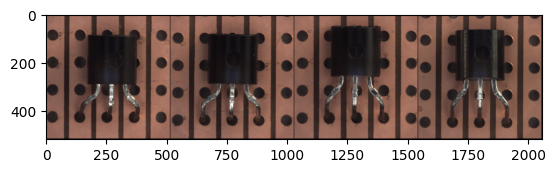

In [88]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [89]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [90]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*13*13, 64),#13*13  #29*29
            nn.ReLU(True),
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256*13*13),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [91]:
testModel = AutoEncoder()
summary(testModel, (3, 512, 512),4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 256, 256]             384
       BatchNorm2d-2           [4, 8, 256, 256]              16
              ReLU-3           [4, 8, 256, 256]               0
            Conv2d-4          [4, 16, 128, 128]           2,048
       BatchNorm2d-5          [4, 16, 128, 128]              32
              ReLU-6          [4, 16, 128, 128]               0
            Conv2d-7            [4, 32, 64, 64]           8,192
       BatchNorm2d-8            [4, 32, 64, 64]              64
              ReLU-9            [4, 32, 64, 64]               0
           Conv2d-10            [4, 64, 32, 32]          32,768
      BatchNorm2d-11            [4, 64, 32, 32]             128
             ReLU-12            [4, 64, 32, 32]               0
           Conv2d-13           [4, 128, 16, 16]         131,072
      BatchNorm2d-14           [4, 128,

Model, Loss & Optimizer

In [92]:
torch.manual_seed(0)

loss = torch.nn.MSELoss()
lr= 0.001
num_epochs = 50

model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs * len(train_dataloader),
      eta_min= 1e-6/lr)

model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train

In [93]:
def train_epoch(model, device, dataloader, loss_fn, optimizer,scheduler):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [94]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [95]:
def plot_ae_outputs(model,n=10):
  # inputs = next(iter(val_dataloader))
  # out = torchvision.utils.make_grid(inputs)
  # imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/50 	 train loss 0.04460747912526131 	 val loss 0.030400525778532028


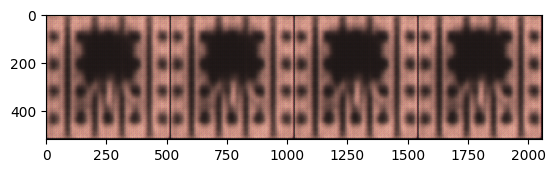


 EPOCH 2/50 	 train loss 0.01048111543059349 	 val loss 0.009976424276828766


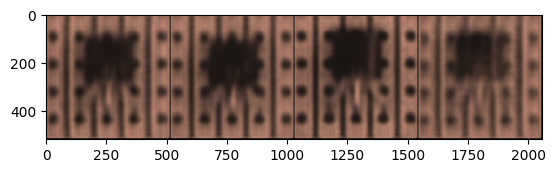


 EPOCH 3/50 	 train loss 0.00651821494102478 	 val loss 0.005706272553652525


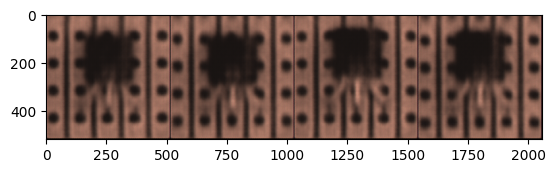


 EPOCH 4/50 	 train loss 0.005379058886319399 	 val loss 0.0053269099444150925


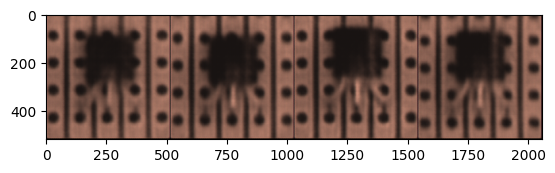


 EPOCH 5/50 	 train loss 0.004993084352463484 	 val loss 0.005124069284647703


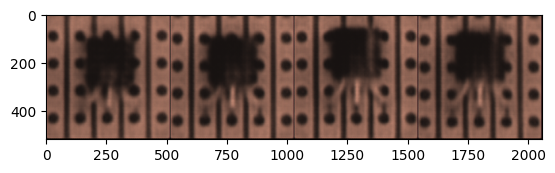


 EPOCH 6/50 	 train loss 0.004610955715179443 	 val loss 0.004853973165154457


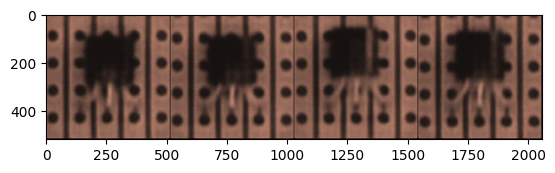


 EPOCH 7/50 	 train loss 0.004449700471013784 	 val loss 0.004556600004434586


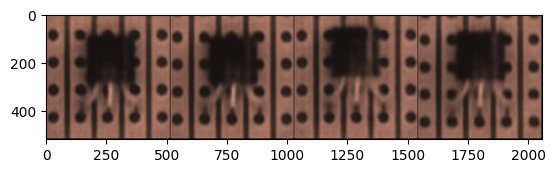


 EPOCH 8/50 	 train loss 0.004337098449468613 	 val loss 0.004559339955449104


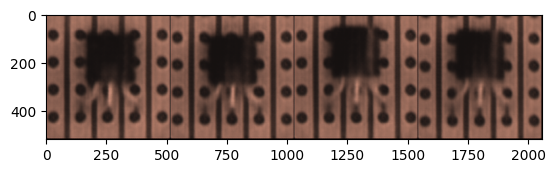


 EPOCH 9/50 	 train loss 0.004142711870372295 	 val loss 0.004046743270009756


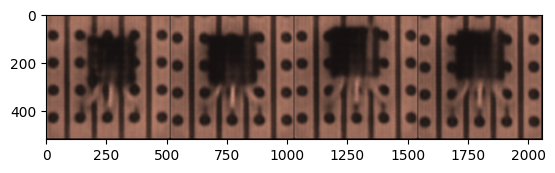


 EPOCH 10/50 	 train loss 0.003766967449337244 	 val loss 0.0037638440262526274


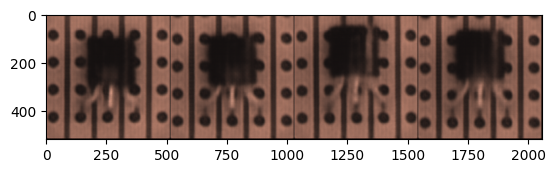


 EPOCH 11/50 	 train loss 0.003571026958525181 	 val loss 0.0038965768180787563


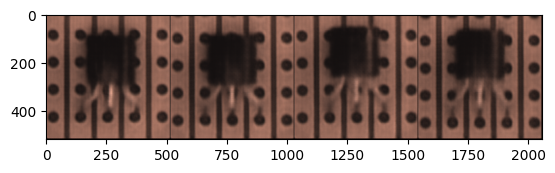


 EPOCH 12/50 	 train loss 0.0036422857083380222 	 val loss 0.004159797448664904


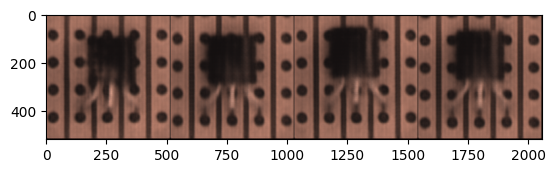


 EPOCH 13/50 	 train loss 0.0036621016915887594 	 val loss 0.0036854716017842293


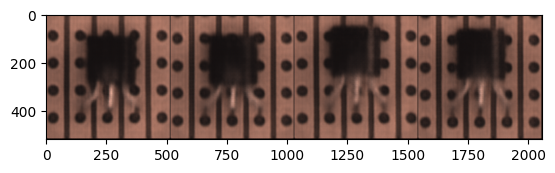


 EPOCH 14/50 	 train loss 0.0033847803715616465 	 val loss 0.0037522863131016493


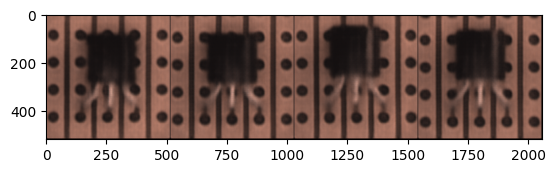


 EPOCH 15/50 	 train loss 0.0032580294646322727 	 val loss 0.004190701525658369


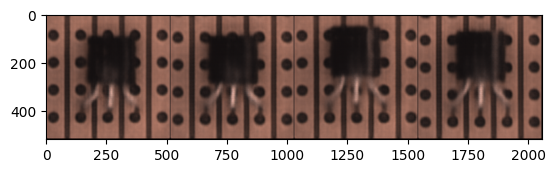


 EPOCH 16/50 	 train loss 0.003500279737636447 	 val loss 0.0039647426456213


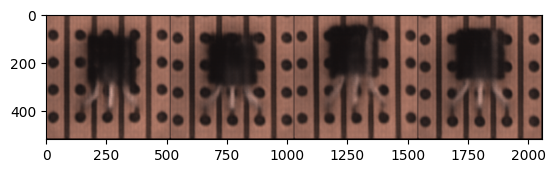


 EPOCH 17/50 	 train loss 0.0034377658739686012 	 val loss 0.004281247965991497


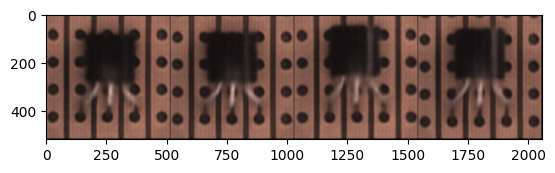


 EPOCH 18/50 	 train loss 0.003577565075829625 	 val loss 0.003919199574738741


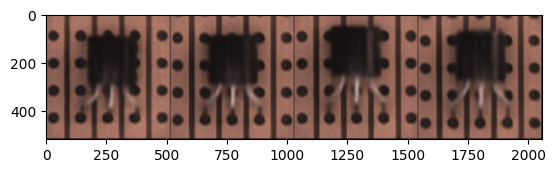


 EPOCH 19/50 	 train loss 0.0031373982783406973 	 val loss 0.0034312671050429344


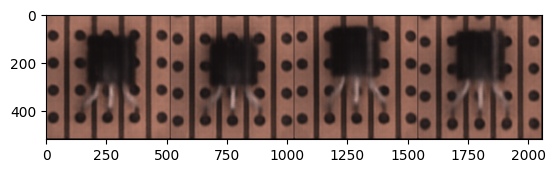


 EPOCH 20/50 	 train loss 0.003094590036198497 	 val loss 0.0035194698721170425


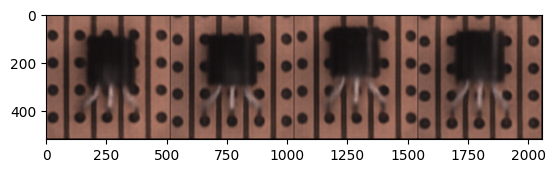


 EPOCH 21/50 	 train loss 0.0030209405813366175 	 val loss 0.0032651410438120365


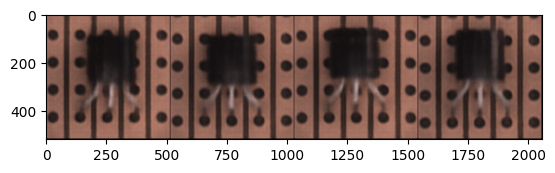


 EPOCH 22/50 	 train loss 0.002888121409341693 	 val loss 0.003608980681747198


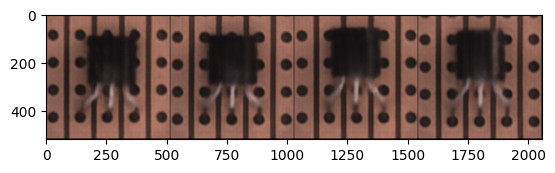


 EPOCH 23/50 	 train loss 0.0028647922445088625 	 val loss 0.0035608396865427494


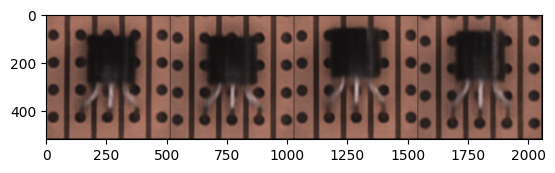


 EPOCH 24/50 	 train loss 0.0028811893425881863 	 val loss 0.003241709666326642


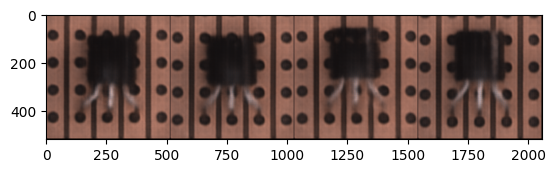


 EPOCH 25/50 	 train loss 0.0028504186775535345 	 val loss 0.0037240292876958847


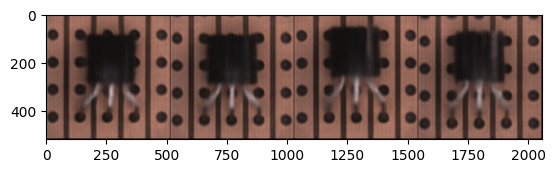


 EPOCH 26/50 	 train loss 0.0028438193257898092 	 val loss 0.0032583200372755527


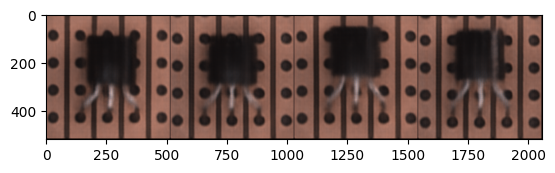


 EPOCH 27/50 	 train loss 0.002834636950865388 	 val loss 0.0031850235536694527


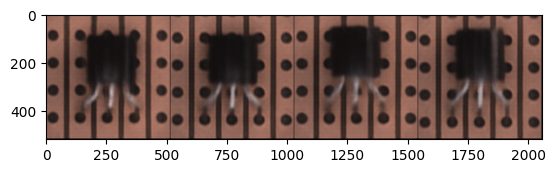


 EPOCH 28/50 	 train loss 0.0028257882222533226 	 val loss 0.0033240877091884613


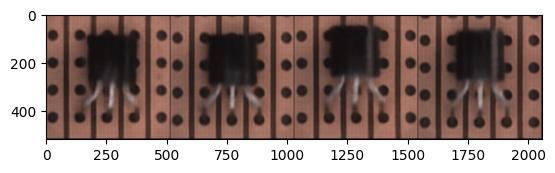


 EPOCH 29/50 	 train loss 0.0027105952613055706 	 val loss 0.003501320956274867


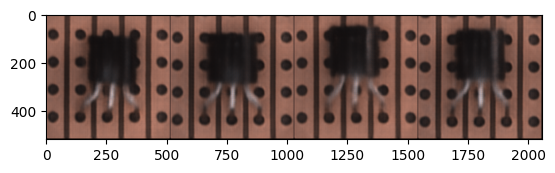


 EPOCH 30/50 	 train loss 0.0028488938696682453 	 val loss 0.0030227380339056253


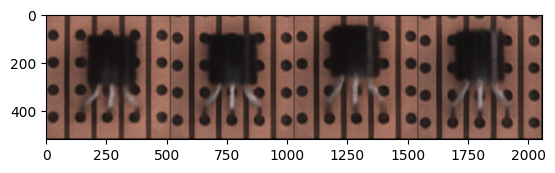


 EPOCH 31/50 	 train loss 0.0027584757190197706 	 val loss 0.00357645470649004


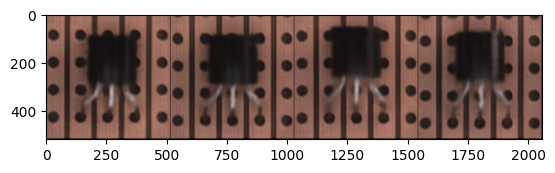


 EPOCH 32/50 	 train loss 0.002762105315923691 	 val loss 0.003103252500295639


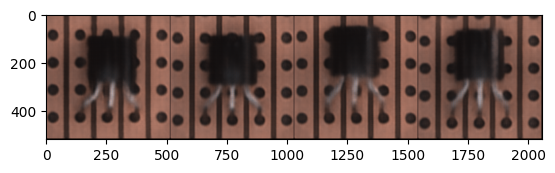


 EPOCH 33/50 	 train loss 0.0027848328463733196 	 val loss 0.0034328072797507048


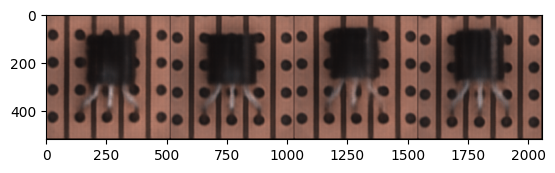


 EPOCH 34/50 	 train loss 0.0024611339904367924 	 val loss 0.0032636348623782396


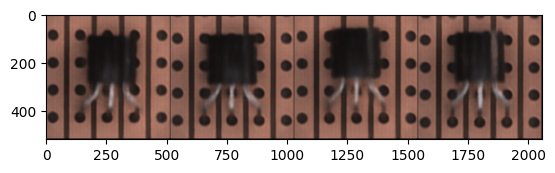


 EPOCH 35/50 	 train loss 0.0024129142984747887 	 val loss 0.0033529961947351694


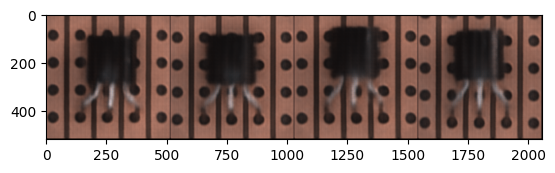


 EPOCH 36/50 	 train loss 0.0024366138968616724 	 val loss 0.0031729263719171286


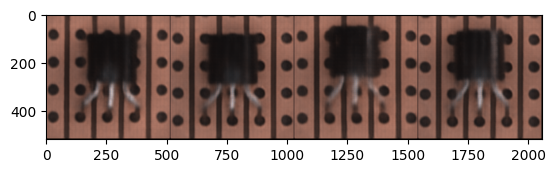


 EPOCH 37/50 	 train loss 0.0024682937655597925 	 val loss 0.002955583855509758


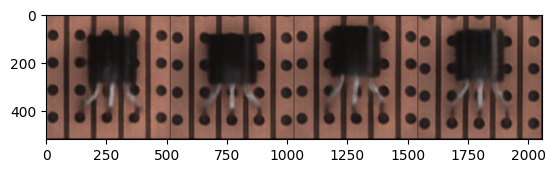


 EPOCH 38/50 	 train loss 0.002489469712600112 	 val loss 0.0029969101306051016


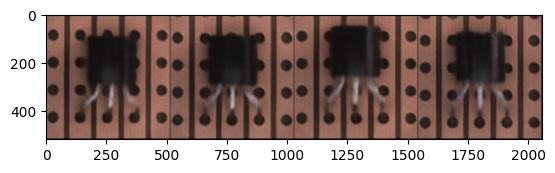


 EPOCH 39/50 	 train loss 0.002450451720505953 	 val loss 0.003125386545434594


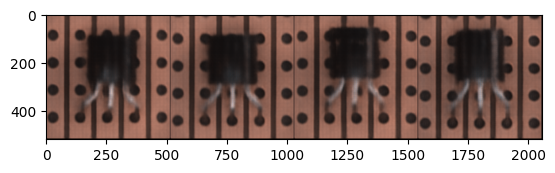


 EPOCH 40/50 	 train loss 0.00238106120377779 	 val loss 0.00312160630710423


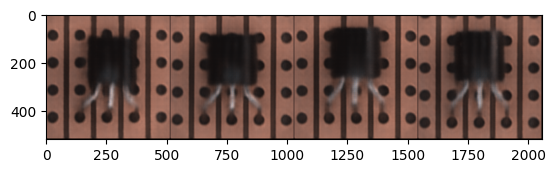


 EPOCH 41/50 	 train loss 0.002521832939237356 	 val loss 0.0035402795765548944


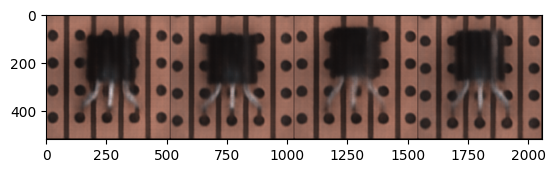


 EPOCH 42/50 	 train loss 0.0025557312183082104 	 val loss 0.003440889995545149


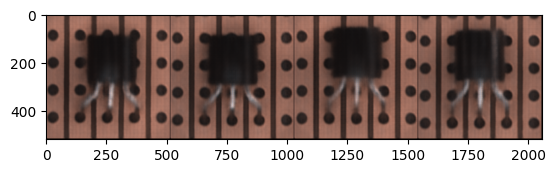


 EPOCH 43/50 	 train loss 0.0023820041678845882 	 val loss 0.003686418989673257


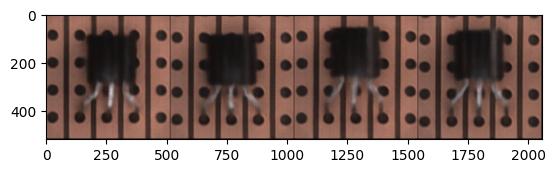


 EPOCH 44/50 	 train loss 0.0024619915056973696 	 val loss 0.003112238831818104


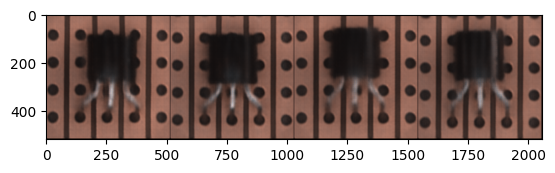


 EPOCH 45/50 	 train loss 0.0024183879140764475 	 val loss 0.0036279514897614717


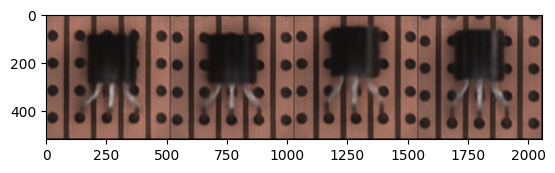


 EPOCH 46/50 	 train loss 0.002395412651821971 	 val loss 0.003019818337634206


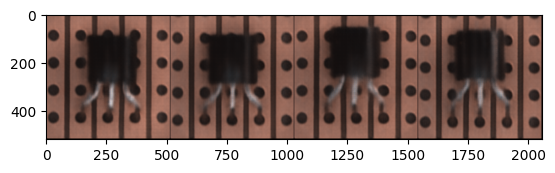


 EPOCH 47/50 	 train loss 0.002440029988065362 	 val loss 0.0032814268488436937


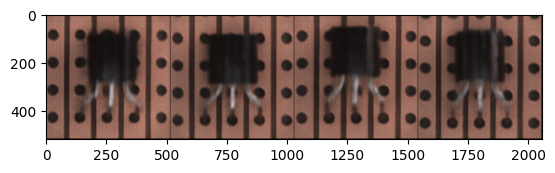


 EPOCH 48/50 	 train loss 0.002432476030662656 	 val loss 0.0034344657324254513


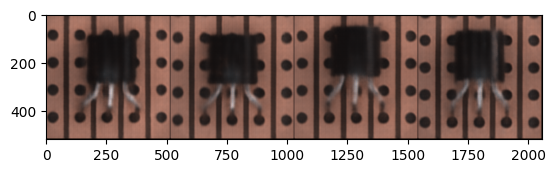


 EPOCH 49/50 	 train loss 0.002387803979218006 	 val loss 0.0032277845311909914


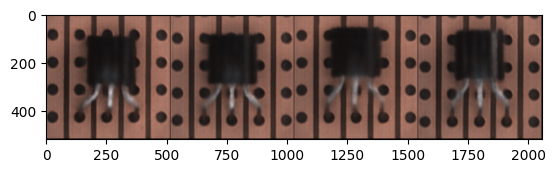


 EPOCH 50/50 	 train loss 0.0025089578703045845 	 val loss 0.003091127146035433


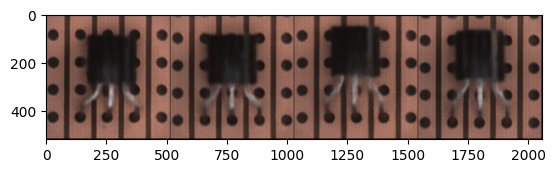

In [96]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim,scheduler)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Temp Section do not delete

torch.Size([1, 3, 512, 512])
tensor([[[[0.1209, 0.5006, 0.5642,  ..., 0.4657, 0.4954, 0.2916],
          [0.4141, 0.4649, 0.5424,  ..., 0.5675, 0.5709, 0.5230],
          [0.5012, 0.5262, 0.5970,  ..., 0.6424, 0.5897, 0.5648],
          ...,
          [0.4352, 0.5083, 0.5333,  ..., 0.6086, 0.5934, 0.4152],
          [0.3831, 0.4785, 0.5037,  ..., 0.5429, 0.5179, 0.4182],
          [0.2304, 0.3899, 0.3616,  ..., 0.4623, 0.4387, 0.2755]],

         [[0.1384, 0.3642, 0.3661,  ..., 0.3117, 0.3522, 0.1807],
          [0.3638, 0.4008, 0.3890,  ..., 0.4124, 0.4217, 0.3729],
          [0.4157, 0.4280, 0.4642,  ..., 0.4315, 0.4118, 0.3715],
          ...,
          [0.2628, 0.3192, 0.4028,  ..., 0.4144, 0.3814, 0.3128],
          [0.2577, 0.3009, 0.3733,  ..., 0.4217, 0.3443, 0.3299],
          [0.1076, 0.2689, 0.2355,  ..., 0.3481, 0.3741, 0.1713]],

         [[0.0828, 0.3107, 0.3187,  ..., 0.2865, 0.2977, 0.2856],
          [0.3086, 0.3641, 0.3758,  ..., 0.3946, 0.3589, 0.3404],
          [0.

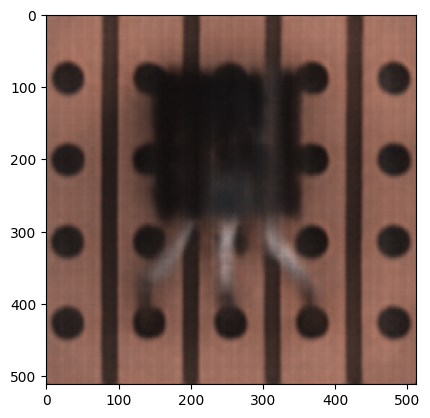

In [97]:
inputs = next(iter(test_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
print(out)
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

Loss Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


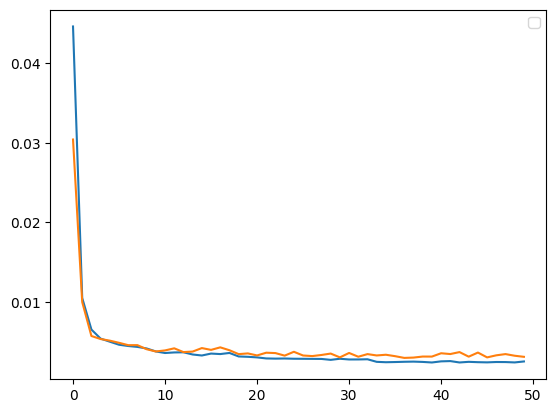

In [98]:
plt.plot(diz_loss['train_loss'])
plt.plot(diz_loss['val_loss'])
plt.legend()
plt.show()

Latent Representation

In [101]:
conc_out = []
with torch.no_grad():
        # for image_batch in val_dataloader:
        #     image_batch = image_batch.to(device)
        #     decoded_data = model.encode(image_batch)
        #     conc_out.append(decoded_data.cpu())
        for image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            conc_out.append(decoded_data.cpu())
        conc_out = torch.cat(conc_out)
torch.set_printoptions(threshold=10_000)
print(conc_out)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  3.8270,  0.0000,  0.0000,  1.9738,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  4.2584,  0.0000,  0.0000,  8.3813,  0.0000,  0.0000,  0.0000,
          0.0000,  2.5638,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  4.9521,
          0.0000,  0.6819,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.8127,  0.1113,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  2.6901,  0.7066,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  3.6541,  0.0000,  0.0000,  0.5021,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.2952,  0.0000,  0.0000,  4.8813,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0676,  3.6755,
          0.0000,  3.4127, 

Encoder-Decoder Output Loss Histogram

In [102]:
model.eval()
ms = []
for image_batch in train_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = loss(decoded_data, image_batch).detach()
    ms.append(mse.cpu().detach().item())

hist, bins = np.histogram(ms, density=False)
print(hist)
print(bins)
#plt.hist(hist,bins = bins, density=False)
#ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.show()

[ 4 12  3 13  4  5  1  0  0  1]
[0.00181737 0.00195905 0.00210074 0.00224242 0.0023841  0.00252579
 0.00266747 0.00280915 0.00295084 0.00309252 0.0032342 ]
